In [1]:
import cv2
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import seaborn as sns

In [84]:
def load_video_to_numpy(video_path, convert_to_rgb=False):
    """
    Load video file into a numpy array of shape (num_frames, height, width, channels).
    
    Args:
        video_path (str): Path to the video file (.avi, .mp4, etc.)
        convert_to_rgb (bool): If True, convert frames from BGR to RGB.
        
    Returns:
        np.ndarray: Video frames as numpy array (num_frames, height, width, 3)
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError(f"Could not open video file: {video_path}")

    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width      = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height     = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_array = np.empty((num_frames, height, width, 3), dtype=np.uint8)

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if convert_to_rgb:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        video_array[frame_idx] = frame
        frame_idx += 1

    cap.release()

    # Trim in case fewer frames were read
    video_array = video_array[:frame_idx]

    return video_array


In [85]:
example_data = load_video_to_numpy('ODA_Dataset-master/dataset/10/10.avi', convert_to_rgb=True)

## Sampling the image data

Below is a couple of different pictures from the image data, the pictures show the movement of the drone when it passes the orange obstacle pilar.  
Our goal is to use these images for estimating the movement of the drone when it flies.

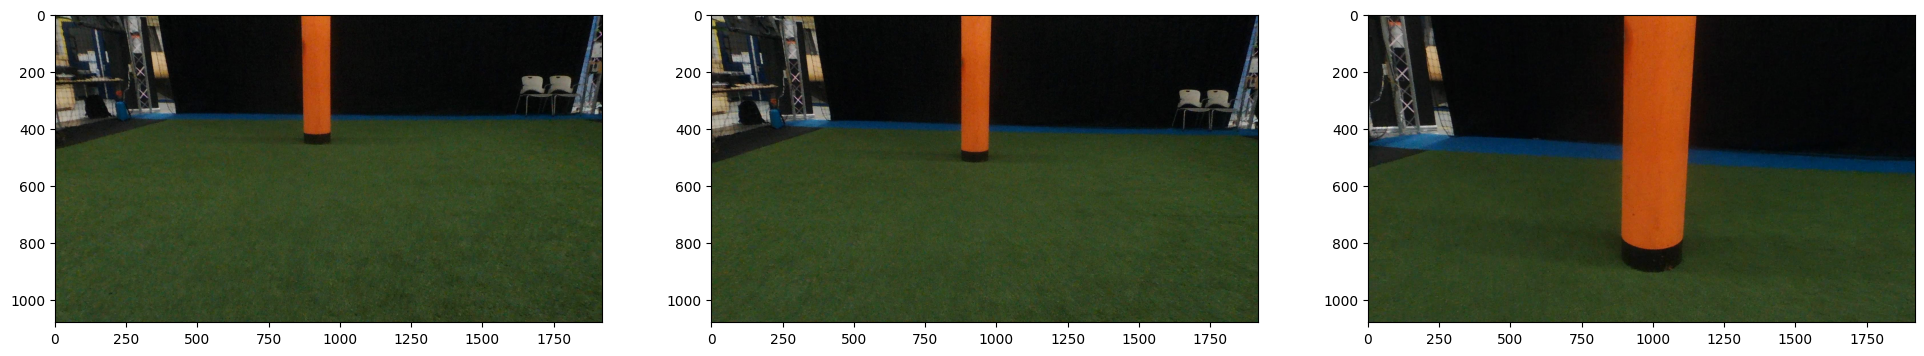

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(24, 14))
ax[0].imshow(example_data[10])
ax[1].imshow(example_data[100])
ax[2].imshow(example_data[200]);

## Detecting features

The first part of our visual odometry method for localization is to find suitable keypoints. These points are used to track the motion of the camera between two successive camera frames $F_i$ and $F_{i + 1}$.  
Finding the keypoints is done by the standard ORB keypoint detector from the Computer Vision 2 library (CV2). 

In [87]:
orb_detector = cv2.ORB_create(nfeatures = 512)

In [88]:
kp1, descriptor1 = orb_detector.detectAndCompute(example_data[0], None)
kp2, descriptor2 = orb_detector.detectAndCompute(example_data[1], None)
descriptor1.shape

(512, 32)

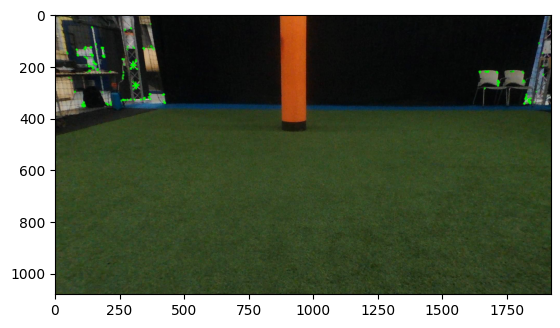

In [89]:
plt.imshow(cv2.drawKeypoints(example_data[0], kp1, None, color=(0, 255, 0), flags=0))

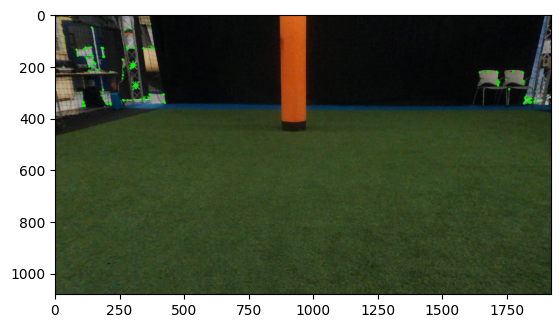

In [90]:
plt.imshow(cv2.drawKeypoints(example_data[1], kp2, None, color=(0, 255, 0), flags=0))

## Matching

Once we have detected and described the keypoints in two frames, the next step is to match them. Matching finds correspondences between the keypoints in frame $F_i$ and frame $F_{i+1}$, which is essential for estimating camera motion.

We use the simple brute force matcher with Hamming distance from CV2 to match the ORB descriptors. Since ORB descriptors are binary strings, the Hamming distance (number of bit flips needed to make the strings match exactly) provides a simple similarity measure. For each keypoint in $F_i$, the matcher finds the keypoint in $F_{i+1}$ with the smallest Hamming distance, giving us a set of matches which correspond to similar points in the frames.


In [91]:
matcher = cv2.BFMatcher(normType=cv2.NORM_HAMMING, crossCheck=True)

In [92]:
matches = matcher.match(descriptor1, descriptor2)

In [93]:
# Find the corresponding points
points_1 = np.array(list(map(lambda x: kp1[x.queryIdx].pt, matches)))
points_2 = np.array(list(map(lambda x: kp2[x.trainIdx].pt, matches)))
assert points_1.shape == points_2.shape, 'not good matches'
print(f"found {points_1.shape[0]} matching keypoints")

found 339 matching keypoints


## Normalize points

Before computing the pose $T \in \text{SE}(3)$, using the essential matrix $E$. We need to normalize the points $x, x'$.   
Let the normalized points be denoted by $\hat{x}, \hat{x}'$.

$$
\hat{x} = K^{-1} x_\text{undistorted}
$$

The point $x$ must however first be undistorted. Both the normalization the undistortion is done using the toolkit of CV2.

In [94]:
# Read calibration data
calibration_data = np.load('./calibration_result.npz')
K, distortion = calibration_data['K'], calibration_data['distortion']

# Undistort and normalize
x_hat = cv2.undistortPoints(np.vstack([points_1, points_2]), K, distortion).reshape(-1, 2)
normalized_points_df = pd.DataFrame({'x': x_hat[:, 0], 'y': x_hat[:, 1], 'frame': [0] * points_1.shape[0] + [1] * points_2.shape[0]})
normalized_points_df

,x,y,frame
0,-0.623996,-0.360761,0
1,-0.621011,-0.360807,0
2,-0.534332,-0.336473,0
3,-0.489185,-0.248116,0
4,-0.538125,-0.340414,0
...,...,...,...
673,-0.538069,-0.348556,1
674,-0.661519,-0.369464,1
675,0.636660,-0.280463,1
676,-0.553948,-0.393748,1


<Axes: xlabel='x', ylabel='y'>

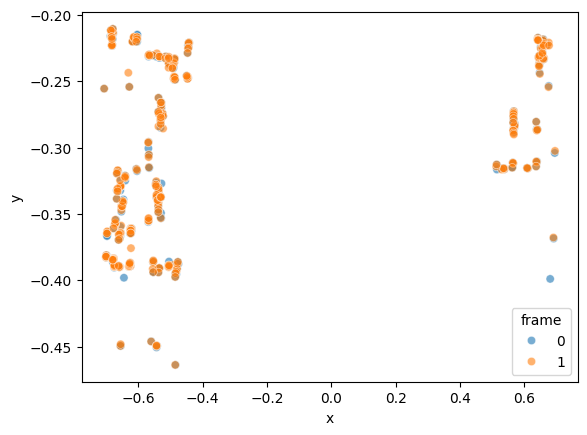

In [95]:
sns.scatterplot(normalized_points_df, x = 'x', y = 'y', hue = 'frame', alpha = 0.6)

In [96]:
# Find the essential matrix E by solving the least squares equation
# x_2^T E x_1 = 0, where x_1 is a vector containing the coordinates (x_1, y_1, 1).
# This constraint is made for each match M.


N = normalized_points_df.shape[0]
mid = N // 2
points_1, points_2 = normalized_points_df.iloc[:mid, :2].to_numpy(), normalized_points_df.iloc[mid:, :2].to_numpy()
stacked_matches = np.array([np.array([x_1 * x_2, y_1 * x_2, x_2, x_1 * y_2, y_1 * y_2, y_2, x_1, y_1, 1]) for (x_1, y_1), (x_2, y_2) in zip(points_1, points_2)])

# Should be M x 9 matrix
assert stacked_matches.shape == (len(matches), 9)
A = stacked_matches[:]

In [97]:
# Perform SVD to obtain the smallest solution to the essential matrix least squares problem
U, S, V_T = np.linalg.svd(A)
E_vec = V_T[-1, :]
E_all_solutions = np.reshape(E_vec, (3, 3))
E_all_solutions

array([[ 0.00858438, -0.63607494, -0.18815631],
       [ 0.62552213,  0.08973068,  0.27551074],
       [ 0.18528357, -0.22438895,  0.00401093]])

In [98]:
U_E, S_E, V_E_T = np.linalg.svd(E_all_solutions)
S_E[-1] = 0.0
E = U_E @ np.diag(S_E) @ V_E_T
E

array([[ 0.00878775, -0.63591989, -0.18866943],
       [ 0.62567154,  0.08984459,  0.27513376],
       [ 0.18476793, -0.22478205,  0.00531189]])

# Pose estimation

From the essential matrix $E$, we can estimate the pose pair $(R, t)$ which describe the pose matrix $T \in \text{SE(3)}$.

$$
T = \begin{bmatrix}
R & t \\
0 & 1
\end{bmatrix}
$$

where $R \in \text{SO}(3)$ and $t \in \mathbb{R}^3$ describe the rotation and translation components.

## Finding R, t

For a given essential matrix $E$, the SVD $E = U \Sigma V^T = U\text{diag}(s, s, 0)V^T$ as there is only one non-zero singular value $s$ for an essential matrix.  
As per the book, there are only 2 possible decompositions of $E$ such that $E = SR$ where $S$ is skew-symmetric, and $R$ is a rotation matrix (belongs to $\text{SO}(3)$).

For both possibilities, $S = UZU^T$, the choice is $R = UWV^T \text{ or } R = UW^TV^T$. The matrices $Z, W$ are defined as

$$
W = \begin{bmatrix}
0 & -1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1
\end{bmatrix}\text{, }
Z = \begin{bmatrix}
0 & 1 & 0 \\
-1 & 0 & 0 \\
0 & 0 & 0
\end{bmatrix}
$$

For the translation $t$, there can also be two possibilities. $t = \pm u_3$, $u_3$ being the third column vector of $U$. In total this makes $4$ possible combinations for the pose of the second camera with respect to the first one. We can eliminate other possibilities by empirically measuring which of these combinations preserves the most amount of points in the second camera, when transformed from the first camera angle.

In [99]:
def generate_possibilites(U:np.ndarray, V: np.ndarray) -> list[tuple[np.ndarray, np.ndarray]]:
    """
    Generates possible rotation and translation components for camera matrix P from essential matrix E SVD decomposition, U and V matrices needed.
    Returns:
        list[tuple[numpy.ndarray]]: list of tuples (R, t) containing the 4 possible rotation and translation options.
    """
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

    t = U[:, 2]

    R1 = U @ W @ V.T
    R2 = U @ W.T @ V.T

    if np.linalg.det(R1) < 0:
        U_r, _, Vt_r = np.linalg.svd(R1)
        U_r[:, -1] = -U_r[:, -1] # Correct the sign
        R1 = U_r @ Vt_r
    

    if np.linalg.det(R2) < 0:
        U_r, _, Vt_r = np.linalg.svd(R2)
        U_r[:, -1] = -U_r[:, -1] # Correct the sign
        R2 = U_r @ Vt_r
    


    return [(R1, t), (R2, t), (R1, -t), (R2, -t)]

In [100]:
x1 = points_1[0]
x2 = points_2[0]

In [101]:
possibilities = generate_possibilites(U_E, V_E_T.T)

### Eliminating possibilities for $P'$

In [102]:
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
P1

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [103]:
P2 = np.hstack([possibilities[0][0], possibilities[0][1].reshape(-1, 1)])
P2

array([[-0.99735783,  0.04823654, -0.05431937, -0.35426231],
       [ 0.06934077,  0.85507831, -0.51384136, -0.2602719 ],
       [ 0.02166139, -0.51625025, -0.8561638 ,  0.89819639]])

In [104]:
def point_triangulation(p1, p2, P1, P2) -> np.array:
    x1, y1 = p1
    x2, y2 = p2
    A = np.vstack([
        x1 * P1[2, :] - P1[0, :],
        y1 * P1[2, :] - P1[1, :],
        x2 * P2[2, :] - P2[0, :],
        y2 * P2[2, :] - P2[1, :]
    ])

    # Solve the problem Az = 0 with Z = (z_1, z_2, z_3, z_4) by creating singular value decomposition of A
    _, _, V_A_T = np.linalg.svd(A)
    Z = V_A_T.T[:, -1]
    Z_prime = Z[:3] / Z[3]
    return Z_prime

In [105]:
triangulated_point = point_triangulation(x1, x2, P1, P2)
triangulated_point

array([ 0.06257266, -0.00290058,  0.06738135])

In [106]:
triangulated_options = []
for option in possibilities:
    R, t = option
    P2 = np.hstack([R, t.reshape(-1, 1)])

    # Loop through the points and triangulate them from the two different positions
    triangulated_points_3d = np.asarray([point_triangulation(p1, p2, P1, P2) for (p1, p2) in zip(points_1, points_2)])

    # Check how many points are in the view of the camera P'
    z = triangulated_points_3d[:, 2]

    # Project the points using the projection matrix
    X_prime = (R @ triangulated_points_3d.T + t.reshape(-1, 1)).T
    z_prime = X_prime[:, 2]

    # How many are in front of both cameras?
    proportion = np.where((z > 0) & (z_prime > 0))[0].shape[0] / X_prime.shape[0]

    # Store results in dictionary
    triangulated_options.append({
        'points': triangulated_points_3d, 
        'matrix': P2, 
        'projected_points': X_prime, 
        'proportion': proportion
    })

In [107]:
# From the options, find the one with maximum proportion
correct_matrix_index = np.argmax(list(map(lambda option: option['proportion'], triangulated_options)))
correct_matrix = triangulated_options[correct_matrix_index]['matrix']
correct_matrix

array([[ 0.74601934,  0.28046918,  0.60398029, -0.35426231],
       [-0.25399588, -0.71857205,  0.64741045, -0.2602719 ],
       [ 0.61558203, -0.63638922, -0.46483063,  0.89819639]])

In [108]:
pose = np.vstack([correct_matrix, np.eye(4)[:, 3]])
pose

array([[ 0.74601934,  0.28046918,  0.60398029, -0.35426231],
       [-0.25399588, -0.71857205,  0.64741045, -0.2602719 ],
       [ 0.61558203, -0.63638922, -0.46483063,  0.89819639],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [109]:
np.linalg.det(pose[:3, :3])

np.float64(1.0)

## Putting it all together

Now we have gone through the steps in the visual odometry pipeline

1. Find keypoint features
2. Match features between frames
3. Normalize and undistort points
4. Compute essential matrix $E$
5. Generate $4$ pose options
6. Triangulate points
7. Find best matching pose option
8. Build pose matrix $T \in \text{SE}(3)$

In [110]:
def obtain_pose(frame1: np.ndarray, frame2: np.ndarray, K: np.ndarray, distortion: np.ndarray) -> np.ndarray:
    orb_detector = cv2.ORB_create(nfeatures = 512)

    # Find points and compute binary string descriptors
    keypoints1, desc1 = orb_detector.detectAndCompute(frame1, None)
    keypoints2, desc2 = orb_detector.detectAndCompute(frame2, None)

    # Match points using the Hamming norm for binary descriptors 
    matcher = cv2.BFMatcher(normType=cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(desc1, desc2)

    # Obtain the matched points as arrays
    matched_points1 = np.asarray(list(map(lambda x: keypoints1[x.queryIdx].pt, matches)))
    matched_points2 = np.asarray(list(map(lambda x: keypoints2[x.trainIdx].pt, matches)))

    # Normalize the points using calibration data K and distortion
    normalized_matches1 = cv2.undistortPoints(matched_points1, K, distortion)[:, 0, :]
    normalized_matches2 = cv2.undistortPoints(matched_points2, K, distortion)[:, 0, :]

    # Homogeneus coordinates
    normalized_matches1_hom = np.hstack([normalized_matches1, np.ones((normalized_matches1.shape[0], 1))])
    normalized_matches2_hom = np.hstack([normalized_matches2, np.ones((normalized_matches2.shape[0], 1))])

    # Compute the essential matrix using SVD, x_1^T E x_2 = 0
    # Form the constraint matrix F such that FE = 0 solves the equation, for (flattened matrix) vector E = (e_1, e_2, ..., e_9)^T
    F = (normalized_matches2_hom[:, :, None] @ normalized_matches1_hom[:, None, :]).reshape(-1, 9)
    
    # Solve the squared error min. problem using SVD
    _, _, F_Vt = np.linalg.svd(F)

    # Take E as the solution with minimal norm, correponding to last vector of U
    E = F_Vt[-1].reshape(3, 3)

    # Fix E to have single eigenvalue with multiplicity 2, and 0 as the last eigenvalue.
    E_U, E_S, E_Vt = np.linalg.svd(E)

    E_S[-1] = 0
    E_fixed = E_U @ np.diag(E_S) @ E_Vt

    # Calculate the possible rotation and translation components R and t:
    E_U, E_S, E_Vt = np.linalg.svd(E_fixed)
    possibilities = generate_possibilites(E_U, E_Vt.T)
    
    triangulated_options = []
    for option in possibilities:
        R, t = option
        P2 = np.hstack([R, t.reshape(-1, 1)])

        # Loop through the points and triangulate them from the two different positions
        # Note: In practice we should just do this for one or two pairs of points since the likelihood that the picked option is wrong is very small, at least accross frames.
        triangulated_points_3d = np.asarray([point_triangulation(p1, p2, P1, P2) for (p1, p2) in zip(points_1, points_2)])

        # Check how many points are in the view of the camera P'
        z = triangulated_points_3d[:, 2]

        # Project the points using the projection matrix
        X_prime = (R @ triangulated_points_3d.T + t.reshape(-1, 1)).T
        z_prime = X_prime[:, 2]

        # How many are in front of both cameras?
        proportion = np.where((z > 0) & (z_prime > 0))[0].shape[0] / X_prime.shape[0]

        # Store results in dictionary
        triangulated_options.append({
            'points': triangulated_points_3d, 
            'matrix': P2, 
            'projected_points': X_prime, 
            'proportion': proportion
        })

    
    # From the options, find the one with maximum proportion
    correct_matrix_index = np.argmax(list(map(lambda option: option['proportion'], triangulated_options)))
    correct_matrix = triangulated_options[correct_matrix_index]['matrix']
    pose = np.vstack([correct_matrix, np.eye(4)[:, 3]])
    return pose


In [111]:
def obtain_pose_cv2(frame1: np.ndarray, frame2: np.ndarray, K: np.ndarray, distortion: np.ndarray) -> np.ndarray:
    orb = cv2.ORB_create(nfeatures=512)
    keypoints1, desc1 = orb.detectAndCompute(frame1, None)
    keypoints2, desc2 = orb.detectAndCompute(frame2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc1, desc2)

    pts1 = np.array([keypoints1[m.queryIdx].pt for m in matches])
    pts2 = np.array([keypoints2[m.trainIdx].pt for m in matches])

    E, _ = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, threshold=1.0, prob=0.999)
    _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)

    pose = np.eye(4)
    pose[:3, :3] = R
    pose[:3, 3] = t.flatten()
    return pose

In [112]:
def check_translation_rotation_treshold(new_pose: np.ndarray, old_pose: np.ndarray) -> bool:
    assert new_pose.shape == old_pose.shape
    assert new_pose.shape == (4, 4)

    # Translational difference
    trans_diff = np.linalg.norm(new_pose[:3, -1] - old_pose[:3, -1])
    rotational_diff = np.degrees((Rotation.from_matrix(new_pose[:3, :3]) * Rotation.from_matrix(old_pose[:3, :3]).inv()).magnitude())
    return (trans_diff >= 0.2) and (rotational_diff >= 5)

In [113]:
N_data = len(example_data)
print(f"Data has {N_data} images.")

Data has 434 images.


In [114]:
N_slam = N_data
step = N_data // N_slam
poses = []
pose_indices = []
pose = np.eye(4)
slam_images = [example_data[i] for i in range(0, N_data, step)]
for i, pair in enumerate(zip(slam_images[:(N_slam - 1)], slam_images[1:])):
    relative_transform = obtain_pose_cv2(pair[0], pair[1], K = K, distortion=distortion)
    new_pose = pose @ relative_transform
    
    # Determine whether or not to save the new pose
    threshold_passed = True # check_translation_rotation_treshold(new_pose, pose)
    if threshold_passed:
        pose = new_pose
        poses.append(pose)
        pose_indices.append(i)
poses = np.asarray(poses)
print(f"Obtained {poses.shape[0]} pose nodes.")

Obtained 433 pose nodes.


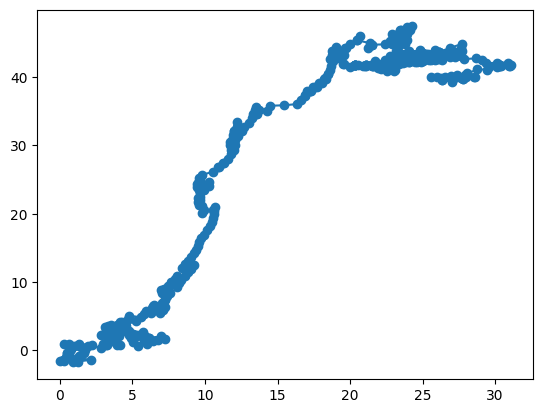

In [115]:
plt.plot(poses[:, 1, -1], poses[:, 0, -1], marker = 'o')

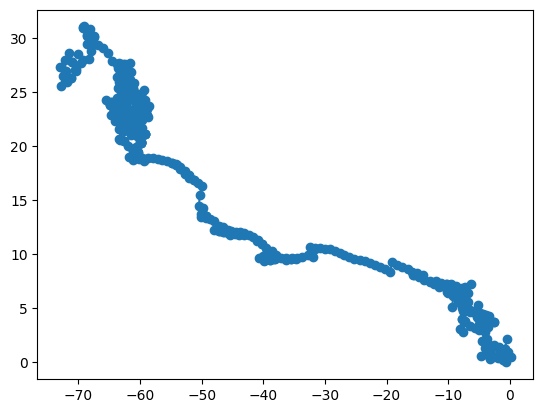

In [116]:
plt.plot(poses[:, 2, -1], poses[:, 1, -1], marker = 'o')

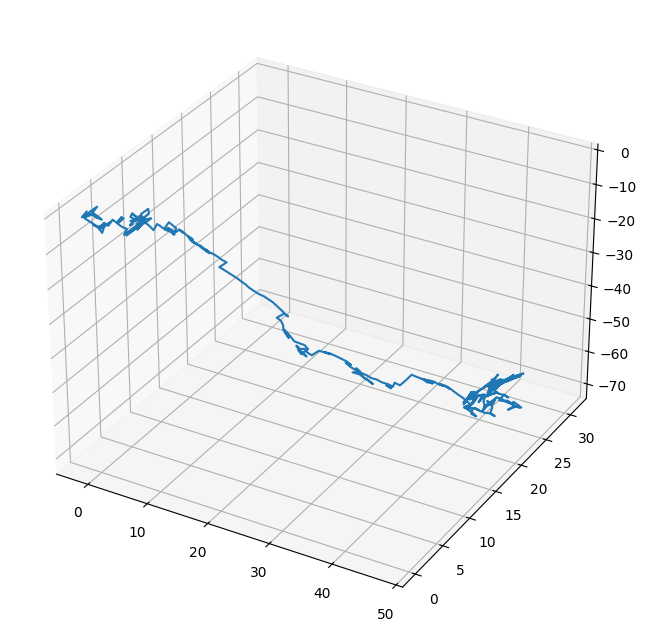

In [117]:
ax = plt.figure(figsize=(16, 8)).add_subplot(projection='3d')
ax.plot(poses[:, 0, -1], poses[:, 1, -1], poses[:, 2, -1])

## Obtaining scale from IMU for localization

We have now built a good pipeline for visual odometry. However the only issue is that we have no sense of scale from the visual odometry alone.   
In other words, we have do not have access to actual metric measures when it comes to our localization and therefore cannot incorporate the visual localization with any other sensors.

To fix this, we take data from the IMU and cross-reference that with the visual odometry results to obtain a sense of scale.

In [129]:
imu_df = pl.read_csv('ODA_Dataset-master/dataset/10/imu.csv')
imu_df.columns = ['t', 'ax', 'ay', 'az', 'p', 'q', 'r']
#imu_df = imu_df.with_columns((pl.col('ay') - 9.81).alias('ay'))
imu_df.describe()

statistic,t,ax,ay,az,p,q,r
str,f64,f64,f64,f64,f64,f64,f64
"""count""",5881.0,5881.0,5881.0,5881.0,5881.0,5881.0,5881.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",7.1098e9,0.18745,9.036242,-2.715715,-0.042079,-0.055502,-0.022257
"""std""",4.2158e9,3.034927,4.399359,2.037527,0.233643,0.131558,0.61375
"""min""",0.0,-6.035449,-9.522598,-9.881851,-1.317732,-0.561394,-1.850364
"""25%""",3.4552e9,-2.524351,5.781577,-4.306245,-0.167247,-0.138484,-0.52411
"""50%""",7.0142e9,0.153281,8.976533,-2.615361,-0.029827,-0.053263,-0.028762
"""75%""",1.0749e10,2.917134,12.152329,-1.058599,0.100135,0.028762,0.485761
"""max""",1.4439e10,6.921606,26.009912,2.304009,1.236772,0.465521,1.662878


### Integration

To obtain the position $(x, y,z)$ from the acceleration, we apply Runge-Kutta 4 double integration scheme. 

In [130]:
def rk4_step(s, a, dt):
    """
    RK4 step for double integration of acceleration to position.
    
    s: current state [pos(3), vel(3)]
    a: acceleration at current timestep (3,)
    dt: timestep
    """
    def f(s, a):
        vel = s[3:]
        return np.hstack((vel, a))
    
    k1 = f(s, a)
    k2 = f(s + 0.5*dt*k1, a)
    k3 = f(s + 0.5*dt*k2, a)
    k4 = f(s + dt*k3, a)
    
    s_next = s + (dt/6) * (k1 + 2 * k2 + 2*k3 + k4)
    return s_next

In [131]:
# Testing the RK4 integrator
t_range = np.linspace(0, 1, num = 10)
current_pos = np.zeros(3)
current_vel = np.zeros(3)
current_acc = np.ones(3)
current_state = np.hstack([current_pos, current_vel])

states = []
for t in t_range:
    new_state = rk4_step(current_state, current_acc, dt = 0.1)
    states.append(new_state)
    current_state = new_state


In [132]:
ns = 1E-9 # nanoseconds
timediff_frames = (imu_df.select('t')[-1][0, 0] / N_slam) * ns
timediff_frames

0.0332694400921659

In [133]:
distances = np.zeros((len(pose_indices), 3))
for i in range(len(pose_indices) - 1):
    # Find the IMU datapoint with the closest timestamp
    starting_time = timediff_frames * pose_indices[i]
    ending_time = timediff_frames * pose_indices[i + 1]
    imu_windows = imu_df.filter((pl.col('t') * ns <= ending_time) & (pl.col('t') * ns >= starting_time))
    current_state = np.zeros(6)
    current_acc = np.zeros(3)
    for imu_window_idx in range(0, imu_windows.height - 1):
        current_df = imu_windows[imu_window_idx]
        next_df = imu_windows[imu_window_idx + 1]
        timediff = (next_df.select('t')[0] - current_df.select('t')[0]).item() * ns
        current_acc = current_df.select(['ax', 'ay', 'az']).to_numpy().flatten()
        next_state = rk4_step(current_state, current_acc, timediff)
        current_state = next_state
    # Distance travelled in each coordinate
    distances[i, :] = current_state[:3]
distances = np.linalg.norm(distances, axis = 1)
print(distances[:2])

[0.00411835 0.00380493]


<Axes: ylabel='Count'>

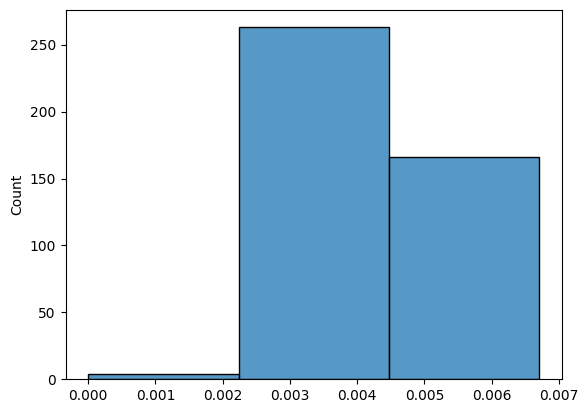

In [134]:
sns.histplot(distances, binwidth=0.002)

Now we can compare the metric measurements gained from integrating the IMU data and the non-metric measurements from visual odometry. 

In [135]:
pose_distances = np.asarray([poses[i + 1, :3, -1] - poses[i, :3, -1] for i in range(len(pose_indices) - 1)])
pose_distances = np.linalg.norm(pose_distances, axis = 1)
pose_distance_scale = np.mean(pose_distances)
print(f"visual odometry has scale {pose_distance_scale:.2f}.")

visual odometry has scale 1.00.


In [137]:
scale_factor = np.mean(distances) / pose_distance_scale
scale_factor

np.float64(0.004322864008582211)

In [138]:
scaled_poses = poses.copy()
scaled_poses[:, :3, -1] = scaled_poses[:, :3, -1] * scale_factor

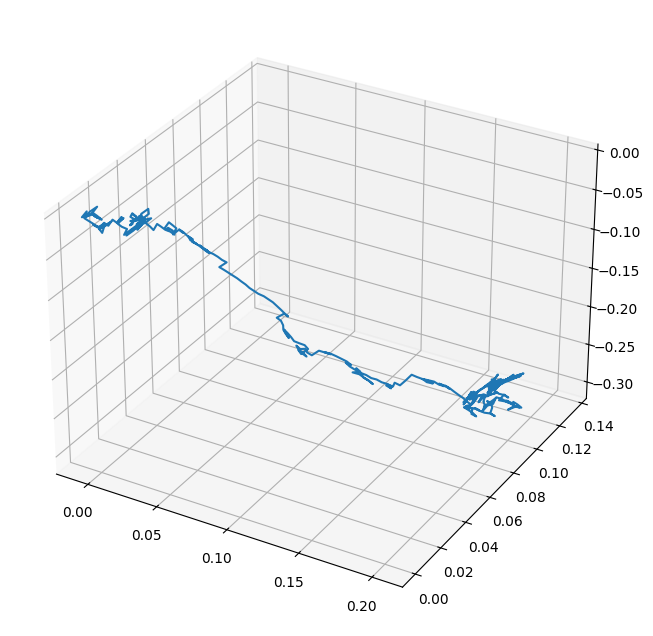

In [139]:
ax = plt.figure(figsize=(16, 8)).add_subplot(projection='3d')
ax.plot(scaled_poses[:, 0, -1], scaled_poses[:, 1, -1], scaled_poses[:, 2, -1])